In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
# hyperparameters config
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1 # 784
batch_size = 32
num_epochs = 50

In [3]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.disc(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, img_dim),
            nn.BatchNorm1d(img_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.gen(x)

In [4]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn(batch_size, z_dim).to(device) # noise generation
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
step = 0

In [5]:
fixed_noise = torch.randn(batch_size, z_dim).to(device)

In [6]:
for epoch in range(num_epochs):
    gen_train_loss, disc_train_loss = 0.0, 0.0
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        # train discriminator
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc_train_loss += lossD
        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # train generator
        disc_output = disc(fake).view(-1)
        lossG = criterion(disc_output, torch.ones_like(disc_output))
        gen_train_loss += lossG
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch: {epoch}\nGenerator Training Loss: {gen_train_loss:.4f}, Discriminator Training loss: {disc_train_loss:.4f}")

Epoch: 0
Generator Training Loss: 3030.9529, Discriminator Training loss: 624.6818
Epoch: 1
Generator Training Loss: 5674.8613, Discriminator Training loss: 209.9402
Epoch: 2
Generator Training Loss: 5259.2168, Discriminator Training loss: 341.7864
Epoch: 3
Generator Training Loss: 3994.0066, Discriminator Training loss: 538.5546
Epoch: 4
Generator Training Loss: 3981.9773, Discriminator Training loss: 540.8971
Epoch: 5
Generator Training Loss: 4216.6484, Discriminator Training loss: 512.3004
Epoch: 6
Generator Training Loss: 4348.7896, Discriminator Training loss: 501.0727
Epoch: 7
Generator Training Loss: 4455.1592, Discriminator Training loss: 490.6758
Epoch: 8
Generator Training Loss: 4555.5068, Discriminator Training loss: 484.5996
Epoch: 9
Generator Training Loss: 4689.3926, Discriminator Training loss: 466.9357
Epoch: 10
Generator Training Loss: 4881.9902, Discriminator Training loss: 446.5625
Epoch: 11
Generator Training Loss: 4995.9497, Discriminator Training loss: 447.6678
Ep

In [28]:
fixed_noise = torch.randn(batch_size, z_dim).to(device)
print(fixed_noise)

tensor([[-0.5446,  0.9664, -0.8994,  ..., -0.8974, -0.3269,  0.4309],
        [-0.0878,  0.2395,  0.0074,  ..., -0.6349, -1.2455, -0.3794],
        [ 0.6357,  1.4191,  1.6754,  ..., -1.0055,  1.5891,  3.3953],
        ...,
        [ 0.0505,  1.1098,  0.2682,  ..., -0.3567,  1.7569,  0.3131],
        [-2.9084, -1.0016,  2.3278,  ...,  0.6526, -0.1664,  1.9167],
        [-1.1575, -0.0300,  1.0293,  ...,  0.2496,  1.2536, -1.3295]],
       device='cuda:0')


In [29]:
image = gen(fixed_noise)

In [30]:
print(image.shape)

torch.Size([32, 784])


In [34]:
img = image[0].reshape(28, 28, 1)

In [35]:
print(img.shape)

torch.Size([28, 28, 1])


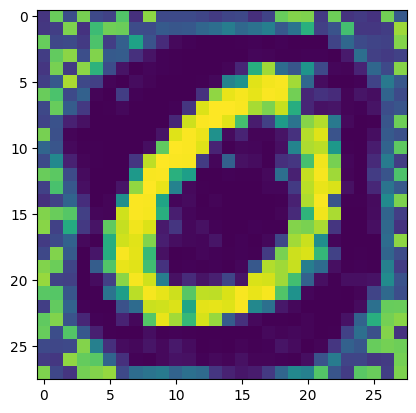

In [36]:
import matplotlib.pyplot as plt

img = img.cpu().detach().numpy()
plt.imshow(img)


In [38]:
torch.save(disc.state_dict(), "discriminator.pth")
torch.save(gen.state_dict(), "generator.pth")